In [1]:
# Respect the import order, otherwise there will be conflicts
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from torch.optim import Adam, AdamW
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import tqdm

# Read the token from the file
with open("huggingface_token.txt", "r") as f:
    token = f.read().strip()

# Authenticate with the token
login(token)

model_name = "meta-llama/Llama-3.2-3B"
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)


# Load the model in 4-bit quantized form for efficiency
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
    torch_dtype=torch.float16
)

2025-01-04 14:47:45.984542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-04 14:47:45.993927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735998466.003202  343877 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735998466.005612  343877 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 14:47:46.015203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# Example query with better generation parameters
prompt = "Quantum Mechanics is a topic inside Physics which deals with"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
)

# Decode and print the response
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Quantum Mechanics is a topic inside Physics which deals with the behavior of matter and energy on a quantum scale. The theory is based on the assumption that the smallest particles of matter (atoms and subatomic particles) are governed by quantum mechanical principles. The term Quantum Mechanics was coined by the German physicist, Max Planck, in 1900, who was trying to explain the mystery of black-body radiation.
The idea behind Quantum Mechanics is that the behavior of atoms is not continuous, as was previously thought, but rather discrete. The discrete behavior is known as


In [3]:
from pykeen.triples import TriplesFactory
import pandas as pd
from neo4j import GraphDatabase

# Define Neo4j connections
host = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(host, auth=(user, password))

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())
    
# Cell 2: Load your graph data
data = run_query("""
    MATCH (s)-[r]->(t)
    RETURN toString(s.name) as source, toString(t.name) AS target, type(r) as type
""")
tf = TriplesFactory.from_labeled_triples(
    data[["source", "type", "target"]].values, compact_id=False
)


training, testing, validation = tf.split([0.8, 0.1, 0.1])

using automatically assigned random_state=327585272


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 240.02s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.08529160435804316. Saved model weights to /home/eddie/.data/pykeen/checkpoints/best-model-weights-5708ab85-a82f-472e-a1ed-3296b6beb130.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/56.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 195.80s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

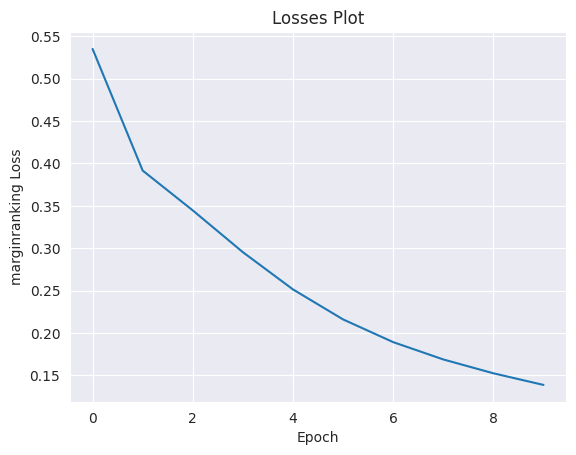

In [4]:
# Baseline
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="RotatE",
    stopper="early",
    epochs=10,
    dimensions=128,
    random_seed=420,
)
result.plot_losses()

In [9]:
from pykeen.models import ERModel
import torch
from pykeen.nn.representation import Embedding
from pykeen.nn.init import init_phases, xavier_uniform_
from pykeen.nn.modules import FunctionalInteraction
from pykeen.utils import negative_norm, ensure_complex

class RotatEDummyEntityRepresentation(Embedding):
    """Entity representation that combines complex RotatE embeddings with dummy embeddings."""

    def __init__(
        self,
        num_entities: int,
        embedding_dim: int,
        dummy_dim: int,
        initializer=xavier_uniform_,
        **kwargs
    ):
        # Initialize complex embeddings for RotatE
        super().__init__(
            max_id=num_entities,
            shape=embedding_dim,
            initializer=initializer,
            dtype=torch.cfloat,
            **kwargs
        )
        
        # Initialize additional dummy embeddings (real-valued)
        self.dummy_embeddings = torch.nn.Embedding(num_entities, dummy_dim)
        torch.nn.init.xavier_uniform_(self.dummy_embeddings.weight)

    def _plain_forward(self, indices=None):
        # Get complex RotatE embeddings
        rotate_embeddings = super()._plain_forward(indices)
        
        if indices is None:
            dummy_embeddings = self.dummy_embeddings.weight
        else:
            dummy_embeddings = self.dummy_embeddings(indices.to(self.device))
            
        return rotate_embeddings, dummy_embeddings

class RotatEDummyInteraction(FunctionalInteraction):
    """Extended RotatE interaction that handles both complex and dummy embeddings."""
    
    def forward(self, h, r, t):
        # Unpack complex and dummy parts
        h_complex, h_dummy = h
        t_complex, t_dummy = t
        r_complex, r_dummy = r
        
        # Regular RotatE score with complex embeddings
        if h_complex.dim() == 3 and r_complex.dim() == 3 and t_complex.dim() == 3:
            h_complex = h_complex.expand(r_complex.shape[0], -1, -1)
            t_complex = t_complex.expand(r_complex.shape[0], -1, -1)
            
        # Compute RotatE interaction in complex space
        rotated_h = h_complex * r_complex
        rotate_score = negative_norm(rotated_h - t_complex, p=2, power_norm=False)
        
        # Handle dummy embeddings with simple multiplication
        if h_dummy.dim() == 3 and r_dummy.dim() == 3 and t_dummy.dim() == 3:
            h_dummy = h_dummy.expand(r_dummy.shape[0], -1, -1)
            t_dummy = t_dummy.expand(r_dummy.shape[0], -1, -1)
            
        dummy_score = (h_dummy * r_dummy * t_dummy).sum(dim=-1)
        
        # Combine scores
        return rotate_score + dummy_score

class RotatEWithDummy(ERModel):
    """RotatE model extended with dummy embeddings."""
    
    def __init__(
        self,
        num_entities: int,
        num_relations: int,
        embedding_dim: int = 200,
        dummy_dim: int = 50,
        entity_initializer=xavier_uniform_,
        relation_initializer=init_phases,
        **kwargs
    ):
        # Initialize entity representations (both complex and dummy)
        entity_representations = RotatEDummyEntityRepresentation(
            num_entities=num_entities,
            embedding_dim=embedding_dim,
            dummy_dim=dummy_dim,
            initializer=entity_initializer
        )
        
        # Initialize relation representations (both complex and dummy)
        relation_representations = RotatEDummyEntityRepresentation(
            num_entities=num_relations,
            embedding_dim=embedding_dim,
            dummy_dim=dummy_dim,
            initializer=relation_initializer
        )
        
        # Initialize the model with custom interaction
        super().__init__(
            entity_representations=entity_representations,
            relation_representations=relation_representations,
            interaction=RotatEDummyInteraction,
            **kwargs
        )

# Pipeline usage
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=RotatEWithDummy,
    model_kwargs={
        'num_entities': tf.num_entities,
        'num_relations': tf.num_relations,
        'embedding_dim': 128,  # Complex embedding dimension
        'dummy_dim': 32,      # Dummy embedding dimension
    },
    optimizer='adam',
    stopper='early',
    epochs=10,
    random_seed=42,
)
result.plot_losses()

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/eddie/.data/pykeen/checkpoints/best-model-weights-fddf306e-9391-40d8-b0f6-642b7a68340c.pt


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 266.68s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.06229972228156377. Saved model weights to /home/eddie/.data/pykeen/checkpoints/best-model-weights-fddf306e-9391-40d8-b0f6-642b7a68340c.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/56.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 230.90s seconds


INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/eddie/.data/pykeen/checkpoints/best-model-weights-87c65e05-dd02-4d35-9797-50166f6a1288.pt


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 91.71s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.0019226660969878231. Saved model weights to /home/eddie/.data/pykeen/checkpoints/best-model-weights-87c65e05-dd02-4d35-9797-50166f6a1288.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/56.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 97.25s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

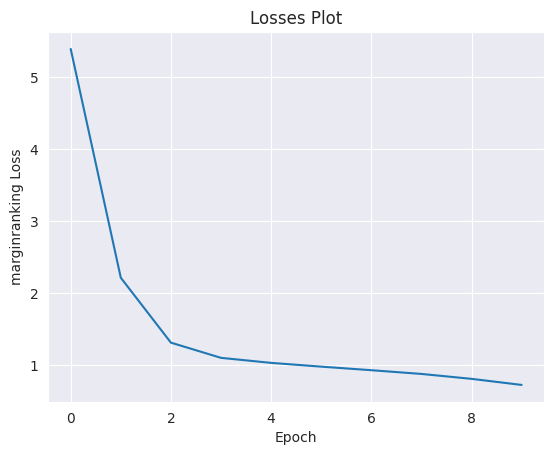

In [5]:
import torch
from pykeen.models import ERModel
from pykeen.nn import Embedding
from pykeen.pipeline import pipeline
from pykeen.datasets import Nations
from pykeen.nn import Interaction


class DummyEntityRepresentation(Embedding):
    """Custom entity representation that concatenates dummy embeddings."""

    def __init__(self, num_entities, embedding_dim, dummy_dim, **kwargs):
        # Initialize regular embeddings for entities
        super().__init__(max_id=num_entities, embedding_dim=embedding_dim, **kwargs)

        # Initialize dummy embeddings for entities
        self.dummy_embeddings = torch.nn.Embedding(num_entities, dummy_dim)
        torch.nn.init.xavier_uniform_(self.dummy_embeddings.weight)

    def _plain_forward(self, indices=None):
        """
        Get regular and dummy embeddings for the given indices.

        Handles the case where indices are None, meaning all embeddings are returned.
        """
        # Get regular embeddings using the super class's _plain_forward method
        regular_embeddings = super()._plain_forward(indices)

        if indices is None:
            # Return all dummy embeddings when indices are None
            dummy_embeddings = self.dummy_embeddings.weight
        else:
            # Lookup specific dummy embeddings
            dummy_embeddings = self.dummy_embeddings(indices.to(self.device))
        
        # Concatenate regular and dummy embeddings along the last dimension
        return torch.cat([regular_embeddings, dummy_embeddings], dim=-1)

class DummyEmbeddingInteraction(Interaction):
    def forward(self, h, r, t):
        
        # Adjust for evaluation
        if h.dim() == 3 and r.dim() == 3 and t.dim() == 3:
            # Broadcasting adjustments:
            # Expand h to match the first dimension of r (batch size or total triples)
            h = h.expand(r.shape[0], -1, -1)
            # Expand t similarly to match r
            t = t.expand(r.shape[0], -1, -1)
        
        # Ensure embedding dimensions match
        if h.size(-1) != r.size(-1) or t.size(-1) != r.size(-1):
            raise ValueError(f"Mismatch in embedding dimensions: "
                             f"h={h.size(-1)}, r={r.size(-1)}, t={t.size(-1)}")
        
        # Compute scores
        return (h * r * t).sum(dim=-1)

class DummyEmbeddingModel(ERModel):
    """Custom model that integrates dummy embeddings into the entity representations."""
    
    def __init__(self, num_entities, num_relations, embedding_dim=50, dummy_dim=50, **kwargs):
        # Initialize the custom entity representation
        entity_representations = DummyEntityRepresentation(
            num_entities=num_entities,
            embedding_dim=embedding_dim,
            dummy_dim=dummy_dim
        )
        
        # Define the custom interaction function
        interaction = DummyEmbeddingInteraction()
        
        # Pass everything to the parent ERModel
        super().__init__(
            entity_representations=entity_representations,
            relation_representations=Embedding,
            relation_representations_kwargs=dict(embedding_dim=embedding_dim + dummy_dim),  # Adjust relation embedding size
            interaction=interaction,
            **kwargs
        )


result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=DummyEmbeddingModel,
    model_kwargs={
        'num_entities': tf.num_entities,
        'num_relations': tf.num_relations,
        'embedding_dim': 128,  # Regular embedding size
        'dummy_dim': 32,  # Dummy embedding size
    },
    optimizer='adam',
    stopper='early',
    epochs=10,
    random_seed=42,
)
result.plot_losses()

In [6]:

import numpy as np

# Function to retrieve and process external context
def get_rag_embedding(entity_name):
    """
    Retrieve and encode Wikidata context for an entity.
    """
    # Retrieve Wikidata context
    if check_wikidata_entry(entity_name, print_results=False):
        # Example text (replace with actual retrieved Wikidata info)
        context = f"Information about {entity_name} retrieved from Wikidata."
    else:
        context = f"No Wikidata context found for {entity_name}."

    # Tokenize and encode the context using Llama
    inputs = tokenizer(context, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # Use the last hidden state as the embedding
    rag_embedding = outputs.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()
    return rag_embedding

def generate_augmented_embeddings(triples_factory):
    """
    Generate embeddings combining Hetionet and RAG features using extracted triples.
    """
    augmented_embeddings = []
    triples = triples_factory.mapped_triples  # Extract triples as tensor [num_triples, 3]
    for triple in tqdm(triples, desc="Generating augmented embeddings"):
        head, relation, tail = triple.tolist()  # Convert tensor to list for indexing
        
        # Get entity labels for head and tail
        head_label = triples_factory.entity_to_id[head]
        tail_label = triples_factory.entity_to_id[tail]
        
        # Generate embeddings
        head_emb = get_rag_embedding(head_label)
        tail_emb = get_rag_embedding(tail_label)
        
        # Concatenate embeddings
        combined_emb = np.concatenate([head_emb, tail_emb])
        augmented_embeddings.append(combined_emb)
    
    return np.array(augmented_embeddings)

# Example: Process training data
training_augmented_embeddings = generate_augmented_embeddings(training)

# Use augmented embeddings in your model pipeline
result = pipeline(
    training=training_augmented_embeddings,
    testing=testing,  # Similarly process testing and validation
    validation=validation,
    model="RotatE",  # Use RotatE or any other model
    stopper="early",
    epochs=4,
    dimensions=256,  # Adjust dimensions to match combined embeddings
    random_seed=420,
)
result.plot_losses()

NameError: name 'tqdm' is not defined

In [ ]:
from typing import Optional
import torch
from torch import nn
import torch.nn.functional as F
from pykeen.models import ERModel
from pykeen.nn import Embedding, Interaction
from transformers import PreTrainedModel, PreTrainedTokenizer

class LLaMaEnhancedInteraction(Interaction):
    def __init__(
        self,
        llama_model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        embedding_dim: int = 256
    ):
        print("Starting Interaction initialization")
        super().__init__()
        
        self.llama = llama_model
        self.tokenizer = tokenizer
        self.embedding_dim = embedding_dim
        
        # Explicitly set dtype for linear layers
        self.llama_projection = nn.Linear(
            self.llama.config.hidden_size,
            embedding_dim,
        ).to(dtype=torch.float32)
        
        self.combine_layer = nn.Linear(
            embedding_dim * 2,
            embedding_dim,
        ).to(dtype=torch.float32)

    def forward(self, h: torch.FloatTensor, r: torch.FloatTensor, t: torch.FloatTensor) -> torch.FloatTensor:
        # Convert entity IDs to text descriptions
        h_ids = torch.arange(len(h), device=h.device)
        t_ids = torch.arange(len(t), device=t.device)
        
        # Get LLaMA embeddings and convert to float32
        h_llama = self._get_llama_embeddings(h_ids).to(dtype=torch.float32)
        t_llama = self._get_llama_embeddings(t_ids).to(dtype=torch.float32)
        
        # Ensure all tensors are float32
        h = h.to(dtype=torch.float32)
        r = r.to(dtype=torch.float32)
        t = t.to(dtype=torch.float32)
        
        # Combine embeddings
        h_combined = self.combine_layer(torch.cat([h, h_llama], dim=-1))
        t_combined = self.combine_layer(torch.cat([t, t_llama], dim=-1))
        
        # Calculate similarity scores
        return torch.sum((h_combined + r) * t_combined, dim=-1)

    def _get_llama_embeddings(self, ids: torch.Tensor) -> torch.Tensor:
        texts = [f"Entity {ent.item()}" for ent in ids]
        inputs = self.tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.llama.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.llama(**inputs)
            # Convert from float16 to float32
            embeddings = outputs.last_hidden_state[:, 0, :].to(dtype=torch.float32)
        
        return self.llama_projection(embeddings)

class LLaMaEnhancedKGEModel(ERModel):
    def __init__(
        self,
        llama_model: PreTrainedModel,
        tokenizer: PreTrainedTokenizer,
        embedding_dim: int = 256,
        **kwargs,
    ) -> None:
        print("Starting model initialization")
        
        # Ensure we're working with the right precision
        self.embedding_dim = embedding_dim
        
        super().__init__(
            interaction=LLaMaEnhancedInteraction,
            interaction_kwargs=dict(
                llama_model=llama_model,
                tokenizer=tokenizer,
                embedding_dim=embedding_dim,
            ),
            entity_representations=Embedding,
            entity_representations_kwargs=dict(
                shape=(embedding_dim,),  # Note: shape must be a tuple
                initializer='xavier_uniform',
            ),
            relation_representations=Embedding,
            relation_representations_kwargs=dict(
                shape=(embedding_dim,),  # Note: shape must be a tuple
                initializer='xavier_uniform',
            ),
            **kwargs,
        )

def create_enhanced_pipeline(
    training,
    testing,
    validation,
    llama_model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    embedding_dim: int = 256,
) -> 'PipelineResult':
    """Create an enhanced pipeline combining LLaMA and PyKEEN models."""
    # Ensure LLaMA is on correct device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    llama_model = llama_model.to(device)
    
    # Create and run pipeline
    result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=LLaMaEnhancedKGEModel,
        model_kwargs={
            'llama_model': llama_model,
            'tokenizer': tokenizer,
            'embedding_dim': embedding_dim,
        },
        optimizer='adam',
        optimizer_kwargs={'lr': 0.001},
        loss='marginranking',
        training_kwargs={
            'num_epochs': 1, 
            'batch_size': 128,
        },
        negative_sampler='basic',
        evaluator='rankbased',
        evaluator_kwargs={'batch_size': 128},
        stopper='early',
        stopper_kwargs={
            'frequency': 5, 
            'patience': 2,
        },
        device=device,
    )
    
    return result

In [39]:
from tqdm import tqdm
import requests

def check_wikidata_entry(name, print_results=True):
    """
    Check if a given name has a corresponding Wikidata entry and optionally print the results.
    """
    url = f"https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "format": "json",
        "language": "en",
        "search": name
    }
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            search_results = data.get("search", [])
            if print_results:
                print(f"Results for '{name}':")
                for result in search_results:
                    print(f" - Label: {result.get('label')}, Description: {result.get('description')}, ID: {result.get('id')}")
            return len(search_results) > 0  # True if at least one match found
    except Exception as e:
        print(f"Error checking {name}: {e}")
    return False

def calculate_match_percentage(names):
    """
    Calculate the percentage of names found in Wikidata.
    """
    unique_names = set(names)  # Ensure uniqueness
    matches = [check_wikidata_entry(name) for name in tqdm(unique_names, desc="Checking Wikidata")]

    found_count = sum(matches)
    total_count = len(unique_names)
    percentage_found = (found_count / total_count) * 100 if total_count > 0 else 0

    return found_count, total_count, percentage_found

# Assuming `data["source"]` is the pandas Series with the names

# Extract names as a list
names = data["source"].dropna().tolist()  # Drop any NaN values for safety

# Calculate match statistics
found_count, total_count, percentage_found = calculate_match_percentage(names)

# Print results
print(f"Checked {total_count} unique entities.")
print(f"Found Wikidata entries for {found_count} entities.")
print(f"Percentage found: {percentage_found:.2f}%")

Checking Wikidata:  10%|█         | 1/10 [00:07<01:10,  7.80s/it]

Results for 'MYOG':
 - Label: Myogenin, Description: mammalian protein found in Mus musculus, ID: Q14906388
 - Label: myogenin, Description: mammalian protein found in Homo sapiens, ID: Q166726
 - Label: Myog, Description: protein-coding gene in the species Mus musculus, ID: Q14906385
 - Label: MYOG, Description: protein-coding gene in the species Homo sapiens, ID: Q14906383
 - Label: myoglobinuria, Description: myopathy that is characterized by an increased urinary excretion of myoglobin, ID: Q1956682
 - Label: MYOG, Description: None, ID: Q62459908
 - Label: MYOG, Description: None, ID: Q61516929


Checking Wikidata:  20%|██        | 2/10 [00:08<00:27,  3.48s/it]

Results for 'PPP1R13L':
 - Label: PPP1R13L, Description: protein-coding gene in the species Homo sapiens, ID: Q18035887
 - Label: Protein phosphatase 1 regulatory subunit 13 like, Description: mammalian protein found in Homo sapiens, ID: Q21110180
 - Label: Ppp1r13l, Description: protein-coding gene in the species Mus musculus, ID: Q18302855
 - Label: Ppp1r13l, Description: protein-coding gene in the species Rattus norvegicus, ID: Q24393765
 - Label: Protein phosphatase 1, regulatory subunit 13 like, Description: mammalian protein found in Mus musculus, ID: Q21498616
 - Label: Protein phosphatase 1, regulatory subunit 13 like, Description: mammalian protein found in Rattus norvegicus, ID: Q29519180
 - Label: PPP1R13L, Description: gene of the species Macaca nemestrina, ID: Q24616154


Checking Wikidata:  30%|███       | 3/10 [00:08<00:14,  2.12s/it]

Results for 'DNAJC24':
 - Label: DNAJC24, Description: protein-coding gene in the species Homo sapiens, ID: Q18049400
 - Label: dnajc24, Description: protein-coding gene in the species Danio rerio, ID: Q29768864
 - Label: Dnajc24, Description: protein-coding gene in the species Mus musculus, ID: Q18271021
 - Label: Dnajc24, Description: protein-coding gene in the species Rattus norvegicus, ID: Q24389771
 - Label: DnaJ heat shock protein family (Hsp40) member C24, Description: mammalian protein found in Homo sapiens, ID: Q21131977
 - Label: DNAJC24, Description: gene of the species Macaca nemestrina, ID: Q24591556
 - Label: DnaJ heat shock protein family (Hsp40) member C24, Description: mammalian protein found in Mus musculus, ID: Q21984431


Checking Wikidata:  40%|████      | 4/10 [00:09<00:08,  1.45s/it]

Results for 'SNW1':
 - Label: SNW domain containing 1, Description: mammalian protein found in Homo sapiens, ID: Q21114222
 - Label: SNW1, Description: protein-coding gene in the species Homo sapiens, ID: Q18036608
 - Label: PRP45, Description: None, ID: Q19051302
 - Label: PRP45, Description: None, ID: Q59907693
 - Label: PRP45, Description: None, ID: Q59970646
 - Label: PRP45, Description: None, ID: Q59953223
 - Label: PRP45, Description: None, ID: Q59952065


Checking Wikidata:  50%|█████     | 5/10 [00:09<00:05,  1.11s/it]

Results for 'OR2AP1':
 - Label: OR2AP1, Description: protein-coding gene in the species Homo sapiens, ID: Q18049420
 - Label: Olfactory receptor family 2 subfamily AP member 1, Description: mammalian protein found in Homo sapiens, ID: Q21120273


Checking Wikidata:  60%|██████    | 6/10 [00:10<00:03,  1.10it/s]

Results for 'PEX16':
 - Label: PEX16, Description: protein-coding gene in the species Homo sapiens, ID: Q18034069
 - Label: Peroxisomal biogenesis factor 16, Description: mammalian protein found in Homo sapiens, ID: Q21122505
 - Label: Pex16, Description: protein-coding gene in the species Mus musculus, ID: Q18252981
 - Label: pex16, Description: protein-coding gene in the species Danio rerio, ID: Q29747711
 - Label: Peroxisome membrane protein, Pex16, Description: InterPro Family, ID: Q24777833
 - Label: Pex16, Description: protein-coding gene in the species Drosophila melanogaster, ID: Q29720790
 - Label: Peroxin 16 Dmel_CG3947, Description: Protein found in Drosophila melanogaster, ID: Q29814840


Checking Wikidata:  70%|███████   | 7/10 [00:10<00:02,  1.35it/s]

Results for 'ASGR1':
 - Label: ASGR1, Description: protein-coding gene in the species Homo sapiens, ID: Q17832212
 - Label: Asgr1, Description: protein-coding gene in the species Mus musculus, ID: Q18247840
 - Label: Asialoglycoprotein receptor 1, Description: mammalian protein found in Homo sapiens, ID: Q21130024
 - Label: Asgr1, Description: protein-coding gene in the species Rattus norvegicus, ID: Q24407404
 - Label: Asialoglycoprotein receptor 1, Description: mammalian protein found in Mus musculus, ID: Q21981205
 - Label: Asialoglycoprotein receptor 1, Description: mammalian protein found in Rattus norvegicus, ID: Q28558636
 - Label: ASGR1, Description: gene of the species Macaca nemestrina, ID: Q24600209


Checking Wikidata:  80%|████████  | 8/10 [00:10<00:01,  1.65it/s]

Results for 'SERPINF2':
 - Label: SERPINF2, Description: protein-coding gene in the species Homo sapiens, ID: Q14864955
 - Label: Serpin family F member 2, Description: mammalian protein found in Homo sapiens, ID: Q4734972
 - Label: Serpinf2, Description: protein-coding gene in the species Mus musculus, ID: Q14864956
 - Label: Serpinf2, Description: protein-coding gene in the species Rattus norvegicus, ID: Q24397353
 - Label: serpinf2a, Description: protein-coding gene in the species Danio rerio, ID: Q29767199
 - Label: Serine (or cysteine) peptidase inhibitor, clade F, member 2, Description: mammalian protein found in Mus musculus, ID: Q14864957
 - Label: Serpin family F member 2, Description: mammalian protein found in Rattus norvegicus, ID: Q29522697


Checking Wikidata:  90%|█████████ | 9/10 [00:11<00:00,  1.84it/s]

Results for 'VEGFC':
 - Label: VEGFC, Description: protein-coding gene in the species Homo sapiens, ID: Q5398950
 - Label: Vascular endothelial growth factor C, Description: mammalian protein found in Homo sapiens, ID: Q7916457
 - Label: Vegfc, Description: protein-coding gene in the species Mus musculus, ID: Q18255311
 - Label: Vascular endothelial growth factor C, Description: mammalian protein found in Mus musculus, ID: Q21992407
 - Label: vegfc, Description: protein-coding gene in the species Danio rerio, ID: Q29752596
 - Label: Vegfc, Description: protein-coding gene in the species Rattus norvegicus, ID: Q24407466
 - Label: VEGFC, Description: gene of the species Macaca nemestrina, ID: Q24586664


Checking Wikidata: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

Results for 'HSFX1':
 - Label: Heat shock transcription factor family, X-linked 2, Description: mammalian protein found in Homo sapiens, ID: Q21132139
 - Label: HSFX1, Description: protein-coding gene in the species Homo sapiens, ID: Q18067945
Checked 10 unique entities.
Found Wikidata entries for 10 entities.
Percentage found: 100.00%
